# PROJETO 8

Objetivo: Tentando reproduzir o material desse link:
https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class2/tfidf_tsne.py

### Passo 0: Bibliotecas

`numpy`: Para operações matemáticas e manipulação de arrays.

`matplotlib.pyplot`: Para visualização gráfica.

`requests`: Para baixar o texto do livro da internet.

`re`: Para manipulação de expressões regulares.

`string`: Para manipulação de caracteres e pontuações.

`sklearn.manifold.TSNE`: Para reduzir a dimensionalidade da matriz TF-IDF e visualizar palavras em 2D.

`sklearn.feature_extraction.text.TfidfTransformer`: Para calcular a transformação TF-IDF.

In [1]:
# import all necessary modules
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import string

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
#nltk.download('punkt')
#nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize, word_tokenize

### Passo 1: Ler os dados e limpar ele

In [2]:
# pegar o text original da internet
book = requests.get('https://www.gutenberg.org/files/35/35-0.txt')

In [3]:
# extrair o texto
text = book.text
print(type(text))
print(len(text))

<class 'str'>
202581


In [4]:
# character strings para trocar por espaços
strings2replace = ["\ufeff",         # beginning
                 '\r\n\r\nâ\x80\x9c', # new paragraph
                 'â\x80\x9c',         # open quote
                 'â\x80\x9d',         # close quote
                 '\r\n',              # new line
                 'â\x80\x94',         # hyphen
                 'â\x80\x99',         # single apostrophe
                 'â\x80\x98',         # single quote
                 '_',                 # underscore, used for stressing
                 ]

In [5]:
# Remove caracteres indesejados que aparecem devido à codificação do texto.
# Substitui esses caracteres por espaços para evitar problemas na tokenização

for str2match in strings2replace:
  regexp = re.compile(r'%s'%str2match)
  text = regexp.sub(' ',text)

In [6]:
text[:1000]

' The Project Gutenberg eBook of The Time Machine, by H. G. Wells  This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook.  Title: The Time Machine  Author: H. G. Wells  Release Date: July, 1992 [eBook #35] [Most recently updated: October 22, 2020]  Language: English  Character set encoding: UTF-8   *** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***     The Time Machine  An Invention  by H. G. Wells   CONTENTS   I Introduction  II The Machine  III The Time Traveller Returns  IV Time Travelling  V In the Golden Age  VI The Sunset of Mankind  VII A Sudden Shock  VIII Explanation  IX The Morlocks  

### Passo 2: Criar Função para Tokenização

- Converte todo o texto para minúsculas (lower()).
- Remove pontuações usando expressões regulares (re.sub(f"[{string.punctuation}]", " ", text)).
- Divide o texto em sentenças usando o ponto "." como separador.
- Divide cada sentença em uma lista de palavras (tokenização).

In [7]:
def tokenize_text_handmade(text):
    text = text.lower()  # Convertendo para minúsculas
    #text = re.sub(f"[{string.punctuation}]", " ", text)  # Removendo pontuações
    sentences = text.split(". ")  # Separando em sentenças
    tokenized_sentences = [sentence.split() for sentence in sentences]  # Tokenizando palavras
    return tokenized_sentences

In [8]:
def tokenize_text(text):
    sentences = sent_tokenize(text)  # Divide o texto em sentenças
    return [word_tokenize(sentence.lower()) for sentence in sentences]  # Tokeniza cada sentença

## Passo 3: Criar o Vocabulário

- Conta a frequência de cada palavra no texto.
- Armazena os resultados no dicionário word_counts.

- Ordena as palavras por frequência decrescente.
- Cria um mapeamento de palavra para índice (word2idx), reservando:
    - START = 0 e END = 1 como tokens especiais.
- Cria o mapeamento reverso (idx2word), convertendo índices de volta para palavras

In [9]:
def build_vocab(sentences, vocab_size=2000):
    word_counts = {}
    for sentence in sentences:
        for word in sentence:
            word_counts[word] = word_counts.get(word, 0) + 1

    # Ordenando palavras por frequência
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:vocab_size]

    # Criando word2idx e idx2word
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_words, start=2)}
    word2idx['START'] = 0
    word2idx['END'] = 1
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    return word2idx, idx2word


### Passo 4: Transformar sentenças em indices

- Substitui cada palavra de uma sentença pelo seu índice correspondente no dicionário word2idx.
- Se a palavra não estiver no vocabulário, usa o índice da palavra "END".
- Remove sentenças vazias (com apenas um índice).

In [10]:
def convert_sentences_to_indices(sentences, word2idx):
    sentences_indices = []  # Lista de listas
    
    for sentence in sentences:
        sentence_indices = [word2idx[word] for word in sentence if word in word2idx]
        sentences_indices.append(sentence_indices)  # Mantém a estrutura correta
    
    return sentences_indices

### Passo 5: Transformação em matriz termo-documento

- Cria uma matriz A de tamanho (V, N), onde:
    - V é o número de palavras no vocabulário.
    - N é o número de sentenças tokenizadas.
- Preenche A[i, j] contando a frequência da palavra i na sentença j.

In [11]:
# Tokenização
sentences_handmade = tokenize_text_handmade(text)
sentences = tokenize_text(text)

len(sentences), len(sentences_handmade)

(1944, 1861)

In [12]:
# Criando vocabulário
word2idx, idx2word = build_vocab(sentences, vocab_size=2000)

# Convertendo sentenças em índices
sentences_indices = convert_sentences_to_indices(sentences, word2idx)

# Criar matriz termo-documento
V = len(word2idx)
N = len(sentences_indices)
A = np.zeros((V, N))
for j, sentence in enumerate(sentences_indices):
    for i in sentence:
        A[i, j] += 1

print("Finished getting raw counts")

Finished getting raw counts


In [13]:
len(sentences)

1944

In [14]:
A.shape

(2002, 1944)

### Passo 6: Aplicar TF-IDF

- Aplica a transformação TF-IDF à matriz A:
- Term Frequency (TF): Frequência de cada termo na sentença.
- Inverse Document Frequency (IDF): Penaliza palavras muito comuns.
- Converte a matriz para um array NumPy.

In [15]:
# Aplicar TF-IDF
transformer = TfidfTransformer()
A = transformer.fit_transform(A.T).T
A = A.toarray()

print(A.shape)

(2002, 1944)


# Passo 7: Aplicar t-SNE

- Reduz a matriz TF-IDF para duas dimensões (2D) usando t-SNE.
- Isso facilita a visualização da distribuição das palavras.

- Plota as palavras em 2D no gráfico scatter.
- Adiciona anotações com as palavras correspondentes.
- Caso alguma palavra tenha caracteres inválidos, ela é ignorada (except).

In [16]:
# Função para verificar se uma palavra é pontuação
def is_punctuation(word):
    return word in string.punctuation

In [17]:
# Mapear índices para palavras
tsne = TSNE()
Z = tsne.fit_transform(A)


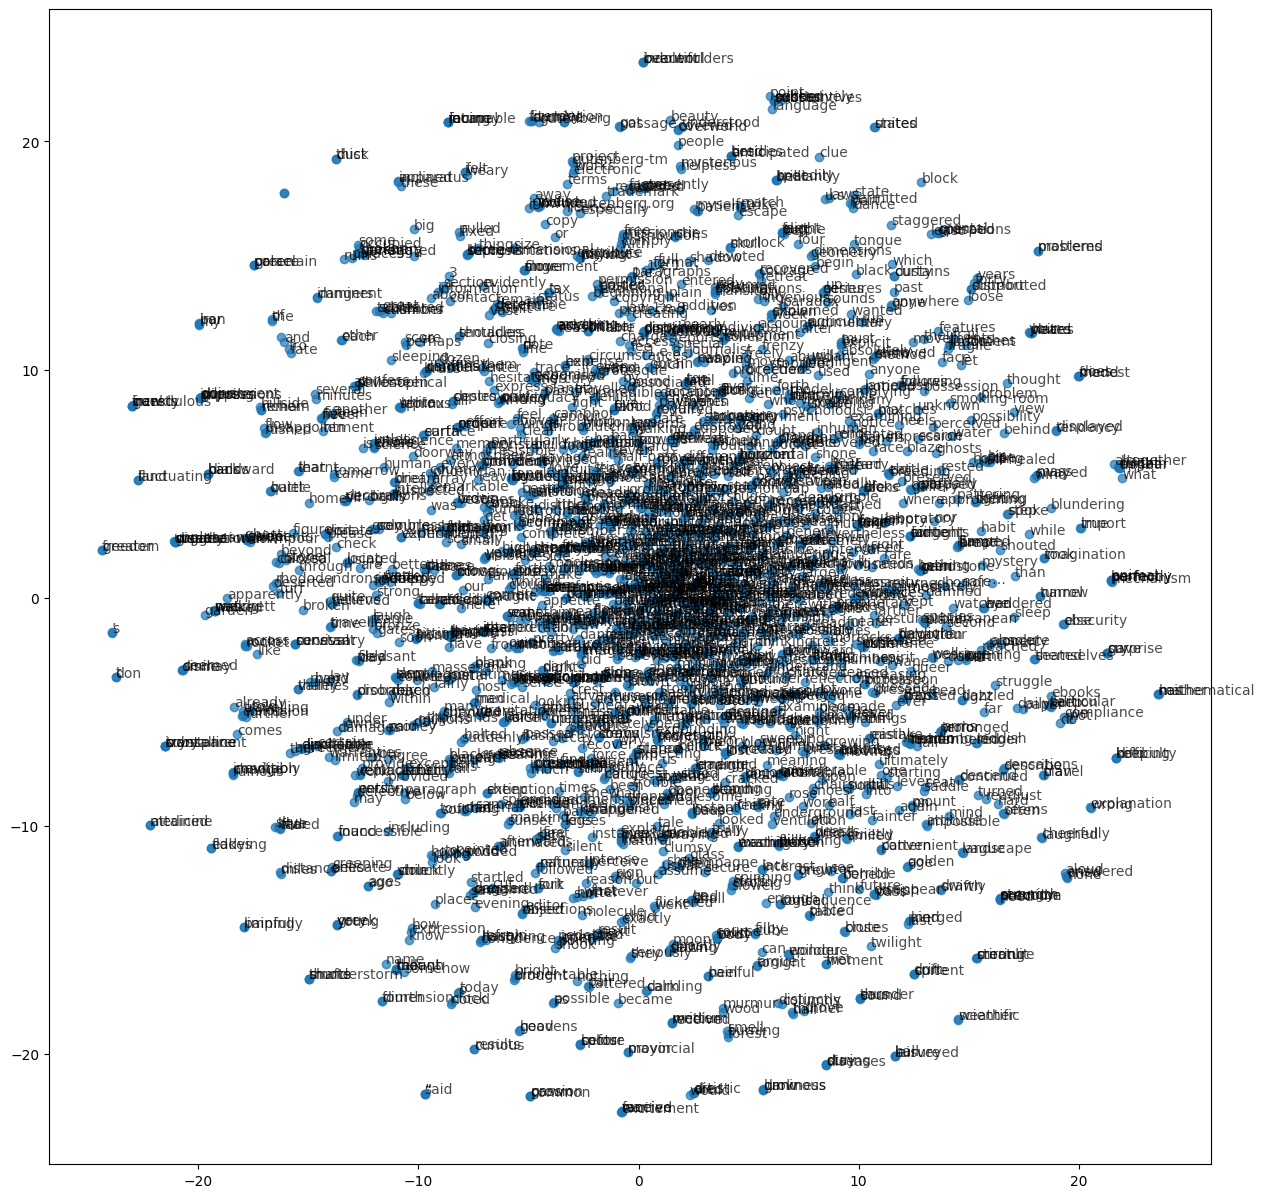

In [18]:
plt.figure(figsize=(15,15))

alpha = 0.7
plt.scatter(Z[:, 0], Z[:, 1], alpha=alpha)

# Iterar sobre as palavras no dicionário idx2word
for idx, word in idx2word.items():
    if is_punctuation(word):  # Ignora palavras de pontuação
        continue
    try:
        plt.annotate(text=word, xy=(Z[idx, 0], Z[idx, 1]), alpha=alpha)  # Corrigido para 'text=word'
    except Exception as e:
        print("Erro ao anotar:", word, e)

plt.show()

In [19]:
def visualize_tsne(A, idx2word, num_words=100, plot_size=(12, 10), alpha=0.7):
    """
    Função para gerar uma visualização do t-SNE de um conjunto de dados com anotações.
    
    Parâmetros:
    - A: matriz termo-documento (V x N)
    - idx2word: dicionário de índices para palavras
    - num_words: número de palavras a exibir
    - plot_size: tamanho da figura
    - alpha: transparência das anotações
    """
    
    # Aplicando o t-SNE
    tsne = TSNE()
    Z = tsne.fit_transform(A)

    # Criando o gráfico
    plt.figure(figsize=plot_size)
    plt.scatter(Z[:, 0], Z[:, 1], alpha=alpha)

    # Iterando sobre as palavras do vocabulário
    for idx, word in list(idx2word.items())[:num_words]:  # Limitando o número de palavras
        if is_punctuation(word):  # Ignorar pontuação
            continue
        try:
            plt.annotate(text=word, xy=(Z[idx, 0], Z[idx, 1]), alpha=alpha)
        except Exception as e:
            print("Erro ao anotar:", word, e)
    
    plt.title("Visualização t-SNE das palavras")
    plt.axis('tight')  # Ajusta automaticamente os limites
    plt.show()

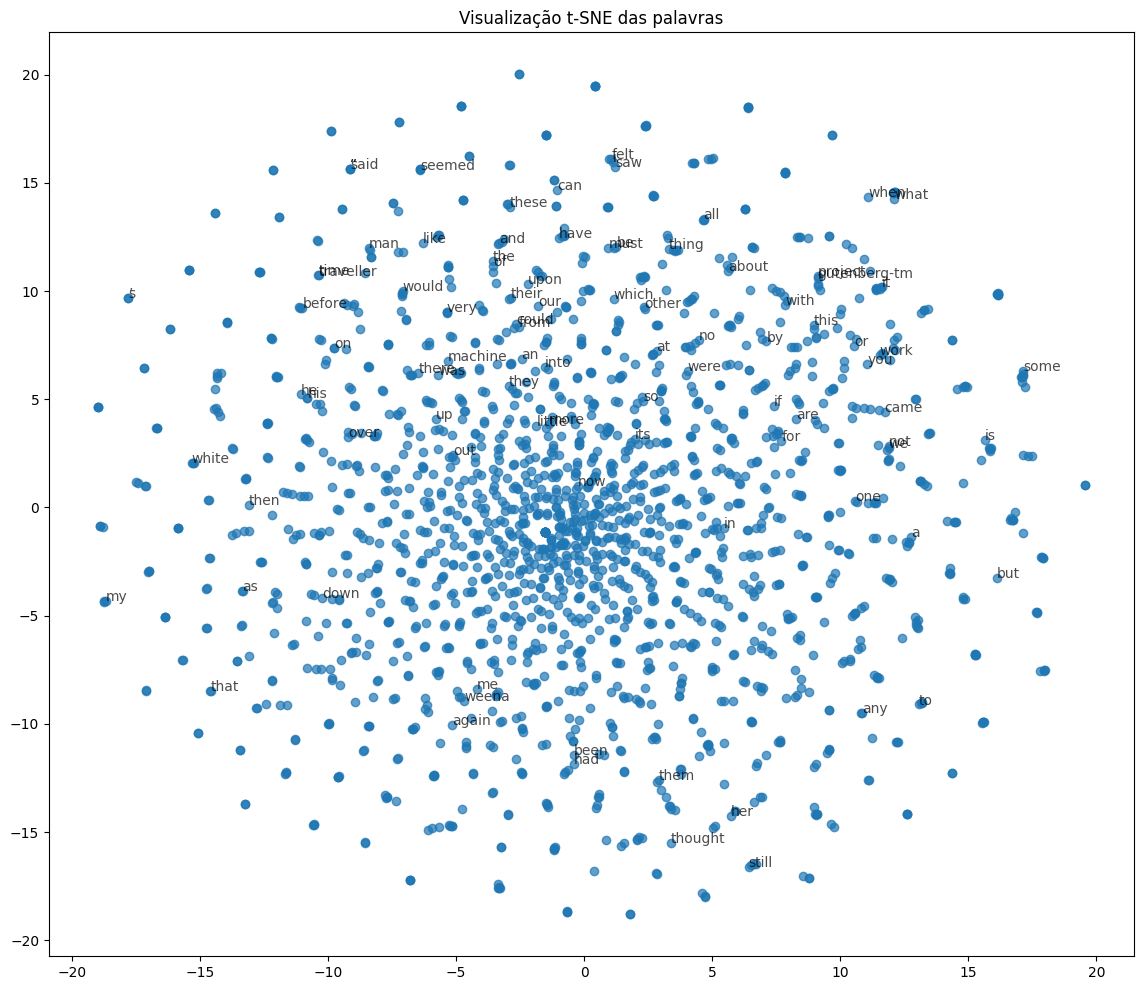

In [20]:
# Usando a função
visualize_tsne(A, idx2word, num_words=100, plot_size=(14, 12), alpha=0.7)